In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='talk', style='ticks',
        color_codes=True, rc={'legend.frameon': False})

%matplotlib inline

In [6]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
import nfp
nfp.__version__

'0.2.0'

bur_vol_loss        0.313611
loss                0.021768
spin_loss           0.006079
val_bur_vol_loss    0.598109
val_loss            0.057768
val_spin_loss       0.025837
dtype: float64


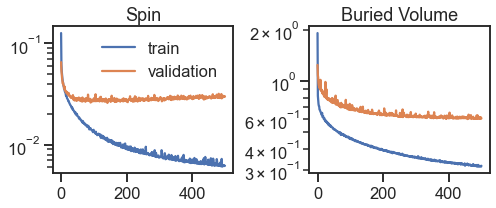

In [11]:
fig, axs = plt.subplots(ncols=2, sharex=True, figsize=(7, 3))

log2 = pd.read_csv('20210215_spin_bv_new_nfp/log.csv', error_bad_lines=False).set_index('epoch')

axs[0].plot(log2['spin_loss'], label='train')
axs[0].plot(log2['val_spin_loss'], label='validation')

axs[0].set_title('Spin')

axs[1].plot(log2['bur_vol_loss'])
axs[1].plot(log2['val_bur_vol_loss'])

axs[1].set_title('Buried Volume')

for ax in axs:
    ax.set_yscale('log')
    
axs[0].legend()

print(log2.min())


plt.tight_layout()
# plt.xlim([0, 10])

In [12]:
from preprocessor import preprocessor

from loss import AtomInfMask, KLWithLogits
from nfp import EdgeUpdate, NodeUpdate, GlobalUpdate
import tensorflow_addons as tfa

model = tf.keras.models.load_model(
    '20210215_spin_bv_new_nfp/best_model.hdf5',
    custom_objects={**nfp.custom_objects,
                    **{'AtomInfMask': AtomInfMask, 'KLWithLogits': KLWithLogits}})

new_model = tf.keras.Model(model.inputs[:3], [tf.nn.softmax(model.outputs[0]), model.outputs[1]])

In [13]:
def parse_example(example):
    parsed = tf.io.parse_single_example(example, features={
        **preprocessor.tfrecord_features,
        **{'spin': tf.io.FixedLenFeature([], dtype=tf.string),
           'bur_vol': tf.io.FixedLenFeature([], dtype=tf.string)}})

    # All of the array preprocessor features are serialized integer arrays
    for key, val in preprocessor.tfrecord_features.items():
        if val.dtype == tf.string:
            parsed[key] = tf.io.parse_tensor(
                parsed[key], out_type=preprocessor.output_types[key])
    
    # Pop out the prediction target from the stored dictionary as a seperate dict
    parsed['spin'] = tf.io.parse_tensor(parsed['spin'], out_type=tf.float64)
    parsed['bur_vol'] = tf.io.parse_tensor(parsed['bur_vol'], out_type=tf.float64)
    
    spin = parsed.pop('spin')
    bur_vol = parsed.pop('bur_vol')
    targets = {'spin': spin, 'bur_vol': bur_vol}
    
    return parsed, targets


batch_size = 128

# Here, we have to add the prediction target padding onto the input padding
# Here, we have to add the prediction target padding onto the input padding
padded_shapes = (preprocessor.padded_shapes(max_atoms=None, max_bonds=None),
                 {'spin': [None], 'bur_vol': [None]})

padding_values = (preprocessor.padding_values,
                  {'spin': tf.constant(np.nan, dtype=tf.float64),
                   'bur_vol': tf.constant(np.nan, dtype=tf.float64)})

dataset = tf.data.TFRecordDataset('tfrecords_spin_bv/valid_new.tfrecord.gz', compression_type='GZIP')\
    .map(parse_example, num_parallel_calls=tf.data.experimental.AUTOTUNE)\
    .padded_batch(batch_size=batch_size,
                  padded_shapes=padded_shapes,
                  padding_values=padding_values)\
    .prefetch(tf.data.experimental.AUTOTUNE)

In [14]:
pred_spins, pred_bur_vols = new_model.predict(dataset)

pred_bur_vols = pred_bur_vols.squeeze()
pred_spins = pred_spins.squeeze()

/projects/rlmolecule/pstjohn/envs/tf2_gpu/lib/python3.7/site-packages/tensorflow/python/keras/engine/functional.py:543: UserWarning: Input dict contained keys ['bond_indices', 'n_atom', 'n_bond'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


In [15]:
dft_spins, dft_bur_vols = [], []
for _, output in dataset.as_numpy_iterator():
    dft_spins += [output['spin']]
    dft_bur_vols += [output['bur_vol']]

dft_spins = np.concatenate(dft_spins)
dft_bur_vols = np.concatenate(dft_bur_vols)

In [16]:
def calc_stability_score(spins, bur_vols):

    max_spin = np.nanmax(spins, 1)
    bur_vol_at_max_spin = np.array([bur_vols[i, j] for i, j in enumerate(np.nanargmax(spins, 1))])

    return bur_vol_at_max_spin + 50 * (1 - max_spin)

In [17]:
dft_stability = calc_stability_score(dft_spins, dft_bur_vols)
pred_stability = calc_stability_score(pred_spins, pred_bur_vols)

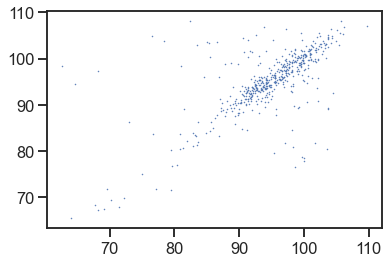

In [18]:
plt.plot(dft_stability, pred_stability, '.', ms=1)

<AxesSubplot:ylabel='Density'>

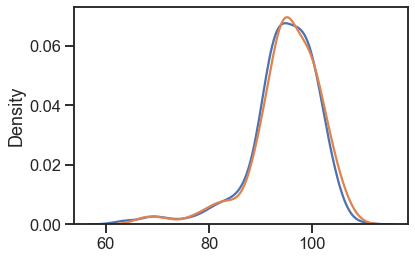

In [19]:
sns.kdeplot(dft_stability)
sns.kdeplot(pred_stability)

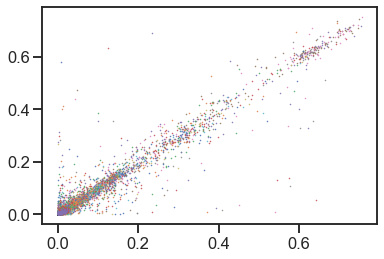

In [20]:
_ = plt.plot(dft_spins, pred_spins, '.', ms=1)

In [21]:
new_model.save('/projects/rlmolecule/pstjohn/models/20210214_radical_stability/', include_optimizer=False)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /projects/rlmolecule/pstjohn/models/20210214_radical_stability/assets
